In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tqdm
import numpy as np
tf.reset_default_graph()
tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE
%matplotlib inline

In [ ]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True
# to log device placement (on which device the operation ran)
config.log_device_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8


In [ ]:
dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)

train_vgg, train_photo = dataset['trainA'], dataset['trainB']
test_vgg, test_photo = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
train_vgg = train_vgg.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_photo = train_photo.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
test_vgg = test_vgg.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
train_vgg = np.asarray([example for example in tfds.as_numpy(train_vgg)])
train_photo = np.asarray([example for example in tfds.as_numpy(train_photo)])
test_vgg = np.asarray([example for example in tfds.as_numpy(test_vgg)])
test_photo = np.asarray([example for example in tfds.as_numpy(test_photo)])

In [ ]:
sample_vgg = train_vgg[0]
sample_photo = train_photo[0]

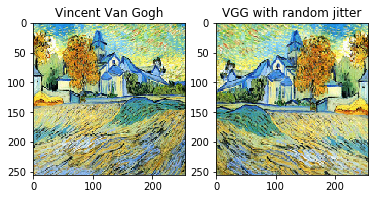

In [14]:
plt.subplot(121)
plt.title('Vincent Van Gogh')
plt.imshow(sample_vgg[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('VGG with random jitter')
plt.imshow(random_jitter(sample_vgg[0]) * 0.5 + 0.5)

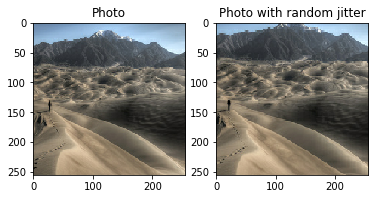

In [15]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

In [ ]:
def resnet_block(inputs, filters, kernel_size, strides, leakyrelu_alpha):
    initializer = tf.random_normal_initializer(0., 0.02)
    conv = tf.layers.conv2d(inputs = inputs, filters = filters, kernel_size = kernel_size, padding = 'same',
                            strides = strides, kernel_initializer=initializer)
    batch_norm = tf.layers.batch_normalization(inputs = conv)
    leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha)
    return leaky_relu

In [ ]:
def upsampling_block(inputs, filters, upsampling_size, input_shape, kernel_size, strides, concat_input):
    initializer = tf.random_normal_initializer(0., 0.02)
    #print("#"*20)
    #print("Input tensor:")
    #print(inputs)
    #print("Input encoder tensor:")
    #print(concat_input)
    up =  tf.image.resize_nearest_neighbor(inputs, (upsampling_size*input_shape[1],upsampling_size*input_shape[2])) # Upsampling
    #print("After upsampling:")
    #print(up)
    conv_dec = tf.layers.conv2d(inputs = up, filters = filters, kernel_size = kernel_size, padding = 'same',
                                strides = strides, kernel_initializer = initializer)
    #print("After conv:")
    #print(conv_dec)
    try:
        batch_norm_dec = tf.layers.batch_normalization(inputs = conv_dec)
        drop_dec = tf.layers.dropout(inputs = batch_norm_dec,rate=0.3)
    except:
        drop_dec = tf.layers.dropout(inputs = conv_dec,rate=0.3)
    concat_dec = tf.concat([drop_dec, concat_input], 3)
    #print("After concat:")
    #print(concat_dec)
    relu_dec = tf.nn.relu(concat_dec)
    #print("#"*20)
    #print("\n")
    return relu_dec

In [ ]:
def generator(z, name, reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        initializer = tf.random_normal_initializer(0., 0.02)
        kernel_size = (4,4)
        strides = (2,2)
        leakyrelu_alpha = 0.2
        upsampling_size = 2
        input_shape = (None, 256, 256, 3)
        
        # --- Encoder network ----
        # - First Convolutional block -
        conv1 = tf.layers.conv2d(inputs = z, filters = 64, kernel_size = kernel_size, padding = 'same',strides = strides)
        leaky_relu1 = tf.nn.leaky_relu(conv1, alpha = leakyrelu_alpha)                   #(bs, 128, 128, 64)
        # - Second Convolutional block -
        resnet2 = resnet_block(leaky_relu1, 128, kernel_size, strides, leakyrelu_alpha)  #(bs, 64, 64, 128)
        # - Third Convolutional block -
        resnet3 = resnet_block(resnet2, 256, kernel_size, strides, leakyrelu_alpha)      #(bs, 32, 32, 256)
        # - Fourth Convolutional block -
        resnet4 = resnet_block(resnet3, 512, kernel_size, strides, leakyrelu_alpha)      #(bs, 16, 16, 512)
        # - Fifth Convolutional block -
        resnet5 = resnet_block(resnet4, 512, kernel_size, strides, leakyrelu_alpha)      #(bs, 8, 8, 512)
        # - Sixth Convolutional block -
        resnet6 = resnet_block(resnet5, 512, kernel_size, strides, leakyrelu_alpha)      #(bs, 4, 4, 512)
        # - Seventh Convolutional block -
        resnet7 = resnet_block(resnet6, 512, kernel_size, strides, leakyrelu_alpha)      #(bs, 2, 2, 512)
        # - Eighth Convolutional block -
        resnet8 = resnet_block(resnet7, 512, kernel_size, strides, leakyrelu_alpha)      #(bs, 1, 1, 512)
        
        # --- Decoder network ----
        # - First Upsampling Convolutional Block -
        up1 = upsampling_block(resnet8, 512, upsampling_size, resnet7.shape, kernel_size, strides, resnet7) #(bs, 2, 2, 1024)
        # - Second Upsampling Convolutional Block -
        up2 = upsampling_block(up1, 1024, upsampling_size, resnet6.shape, kernel_size, strides, resnet6)   #(bs, 4, 4, 1536)
        # - Third Upsampling Convolutional Block -
        up3 = upsampling_block(up2, 1024, upsampling_size, resnet5.shape, kernel_size, strides, resnet5)   #(bs, 8, 8, 1536)
        # - Fourth Upsampling Convolutional Block -  
        up4 = upsampling_block(up3, 1024, upsampling_size, resnet4.shape, kernel_size, strides, resnet4)   #(bs, 16, 16, 1536)
        # - Fifth Upsampling Convolutional Block -
        up5 = upsampling_block(up4, 1024, upsampling_size, resnet3.shape, kernel_size, strides, resnet3)   #(bs, 32, 32, 1280)
        # - Sixth Upsampling Convolutional Block - 
        up6 = upsampling_block(up5, 512, upsampling_size, resnet2.shape, kernel_size, strides, resnet2)    #(bs, 64, 64, 620)
        # - Seventh Upsampling Convolutional Block -
        up7 = upsampling_block(up6, 256, upsampling_size, leaky_relu1.shape, kernel_size, strides, leaky_relu1)  #(bs, 128, 128, 320)
        # - Last Upsampling Convolutional Block -
        up =  tf.image.resize_nearest_neighbor(up7, (512, 512)) # Upsampling
        up8 = tf.layers.conv2d(inputs = up, filters = 3, kernel_size = kernel_size, padding = 'same',
                               strides = strides, kernel_initializer = initializer) #(bs, 256, 256, 3)
        
        return tf.nn.tanh(up8)

In [ ]:
def discriminator(inputs, name, reuse=None):
    with tf.variable_scope(name,reuse=reuse):
        initializer = tf.random_normal_initializer(0., 0.02)
        kernel_size = (4,4)
        strides = (2,2)
        leakyrelu_alpha = 0.2
        input_shape = (None, 256, 256, 3)
        # Just 7 resnet blocks
        # - First Convolutional block -
        resnet1 = resnet_block(inputs, 64, kernel_size, strides, leakyrelu_alpha)
        # - Second Convolutional block -
        resnet2 = resnet_block(resnet1, 128, kernel_size, strides, leakyrelu_alpha)
        # - Third Convolutional block -
        resnet3 = resnet_block(resnet2, 256, kernel_size, strides, leakyrelu_alpha)
        # - Fourth Convolutional block -
        resnet4 = resnet_block(resnet3, 512, kernel_size, strides, leakyrelu_alpha)
        # - Fifth Convolutional block -
        resnet5 = resnet_block(resnet4, 512, kernel_size, strides, leakyrelu_alpha)
        # - Sixth Convolutional block -
        resnet6 = resnet_block(resnet5, 512, kernel_size, strides, leakyrelu_alpha)
        # - Seventh Convolutional block -
        conv = tf.layers.conv2d(inputs = resnet6, filters = 512, kernel_size = kernel_size, padding = 'same',
                            strides = strides, kernel_initializer=initializer)
        batch_norm = tf.layers.batch_normalization(inputs = conv)
        leaky_relu = tf.nn.leaky_relu(batch_norm, alpha = leakyrelu_alpha)
        
        
        # Add a flatten layer
        flatten = tf.layers.flatten(leaky_relu)

        # Add the final dense layer
        dense_layer = tf.layers.dense(inputs = flatten,  units=2, activation='softmax')
        
        return dense_layer

In [ ]:
tf.disable_eager_execution()

In [ ]:
input_vgg = tf.placeholder(tf.float32,shape=[None,256,256,3],name="input_vgg")
input_photo = tf.placeholder(tf.float32,shape=[None,256,256,3],name="input_photo")
cycle_image_real = tf.placeholder(tf.float32,shape=[None,256,256,3],name="cycle_image_real")
cycle_image_gen = tf.placeholder(tf.float32,shape=[None,256,256,3],name="cycle_image_gen")
disc_image_real = tf.placeholder(tf.float32,shape=[None,256,256,3],name="disc_image_real")
disc_image_fake = tf.placeholder(tf.float32,shape=[None,256,256,3],name="disc_image_fake")
gen_loss_input = tf.placeholder(tf.float32,shape=[1,2],name="gen_loss_input")

In [ ]:
generator_photo = generator(input_vgg,"gen_photo_from_vgg") # Takes VGG images to generate photos
generator_vgg = generator(input_photo,"gen_vgg_from_photo") # Takes photo images to generate VGG

In [ ]:
cycle_generator_photo = generator(generator_photo,"gen_photo_from_photo") # Takes generated photos to generate photos
cycle_generator_vgg   = generator(generator_vgg,"gen_vgg_from_vgg")       # Takes generated vgg to generate vgg

In [24]:
discriminator_vgg = discriminator(input_vgg,"disc_vgg") # Discriminate vgg from input vgg
discriminator_photo = discriminator(input_photo,"disc_photo") # Discriminate photo from input photo

Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


In [ ]:
discriminator_gen_vgg   = discriminator(generator_vgg,"disc_gen_vgg", reuse=tf.AUTO_REUSE) # Discriminate vgg from generated vgg
discriminator_gen_photo = discriminator(generator_photo,"disc_gen_vgg", reuse=tf.AUTO_REUSE) # Discriminate photo from generated photo

In [ ]:
def discriminator_loss(disc_image_real, disc_image_fake):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_image_real), logits=disc_image_real)
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(disc_image_fake), logits=disc_image_fake)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [ ]:
def generator_loss(gen_loss_input):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(gen_loss_input), logits=gen_loss_input)

In [ ]:
def cycle_loss(cycle_image_real, cycle_image_gen):
    LAMBDA = 100
    loss1 = tf.reduce_mean(tf.abs(cycle_image_real - cycle_image_gen))
    return LAMBDA*loss1

In [ ]:
# Optimizers
generator_vgg_optimizer = tf.train.AdamOptimizer(2e-4)
generator_photo_optimizer = tf.train.AdamOptimizer(2e-4)

discriminator_vgg_optimizer = tf.train.AdamOptimizer(2e-4)
discriminator_photo_optimizer = tf.train.AdamOptimizer(2e-4)

In [ ]:
EPOCHS = 40
LAMBDA = 10

In [43]:
sess.run(tf.global_variables_initializer())
for epoch in tqdm.tqdm(range(EPOCHS), total = EPOCHS):
    for image_vgg, image_photo in zip(train_vgg, train_photo):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_vgg, fake_photo = sess.run([generator_vgg,generator_photo],feed_dict={input_vgg:image_photo, 
                                                                                   input_photo:image_vgg})

            cycled_photo, cycled_vgg = sess.run([cycle_generator_photo, cycle_generator_vgg],
                                            feed_dict={generator_photo:fake_photo, generator_vgg:fake_vgg})


            disc_real_vgg, disc_real_photo = sess.run([discriminator_vgg, discriminator_photo], feed_dict={input_vgg:image_vgg,
                                                                                                   input_photo:image_photo})

            disc_fake_vgg, disc_fake_photo = sess.run([discriminator_vgg, discriminator_photo], feed_dict={input_vgg:fake_vgg,
                                                                                                   input_photo:fake_photo})

            # calculate the loss
            gen_vgg_loss = generator_loss(disc_fake_photo)
            gen_photo_loss = generator_loss(disc_fake_vgg)
            
            cycle_vgg_loss = cycle_loss(image_vgg, cycled_vgg)
            cycle_photo_loss = cycle_loss(image_photo, cycled_photo)
            
            total_cycle_loss = cycle_vgg_loss + cycle_photo_loss

        # Total generator loss = adversarial loss + cycle loss
        total_gen_vgg_loss = gen_vgg_loss + total_cycle_loss 
        total_gen_photo_loss = gen_photo_loss + total_cycle_loss
        #print(total_gen_vgg_loss.eval(session=sess), total_gen_photo_loss.eval(session=sess))

        disc_vgg_loss = discriminator_loss(disc_real_vgg, disc_fake_vgg)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

        #print(disc_vgg_loss.eval(session=sess), disc_photo_loss.eval(session=sess))

        # Calculate the gradients for generator and discriminator
        generator_g_gradients = gen_tape.gradient(total_gen_vgg_loss, 
                                            tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"gen_photo_from_vgg"))
        generator_f_gradients = gen_tape.gradient(total_gen_photo_loss, 
                                            tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"gen_vgg_from_photo"))

        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                        discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                discriminator_y.trainable_variables)
        # Apply the gradients to the optimizer
        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                generator_g.trainable_variables))

        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                generator_f.trainable_variables))

        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    discriminator_x.trainable_variables))

        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    discriminator_y.trainable_variables))



  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored